# A Simple Case Study using Wage Data from 2015

We illustrate how to predict an outcome variable $Y$ in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. We use linear prediction rules for estimation, including OLS and the penalized linear methods we've studied. Later, we will also consider nonlinear prediction rules including tree-based methods and neural nets.

In [9]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression, Ridge
import patsy
import warnings
from sklearn.base import BaseEstimator
import statsmodels.api as sm
warnings.simplefilter('ignore')
np.random.seed(1234)

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

Set the following file_directory to a place where you downloaded https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv

In [ ]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)

In [10]:
data.describe()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,23.410410,2.970787,0.444466,0.023301,0.243883,0.278058,0.317670,0.137087,0.259612,0.296505,0.216117,0.227767,13.760583,3.018925,8.235867,25.118038,5310.737476,11.670874,6629.154951,13.316893
std,21.003016,0.570385,0.496955,0.150872,0.429465,0.448086,0.465616,0.343973,0.438464,0.456761,0.411635,0.419432,10.609465,4.000904,14.488962,53.530225,11874.356080,6.966684,5333.443992,5.701019
min,3.021978,1.105912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,370.000000,2.000000
25%,13.461538,2.599837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500,1740.000000,5.000000,4880.000000,9.000000
50%,19.230769,2.956512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,4040.000000,13.000000,7370.000000,14.000000
75%,27.777778,3.324236,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,21.000000,4.410000,9.261000,19.448100,5610.000000,17.000000,8190.000000,18.000000
max,528.845673,6.270697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100,100000.000000,22.000000,100000.000000,22.000000


In [11]:
y = np.log(data['wage']).values #.values 返回Numpy数组而不是series
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

(0.0, 3000.0)

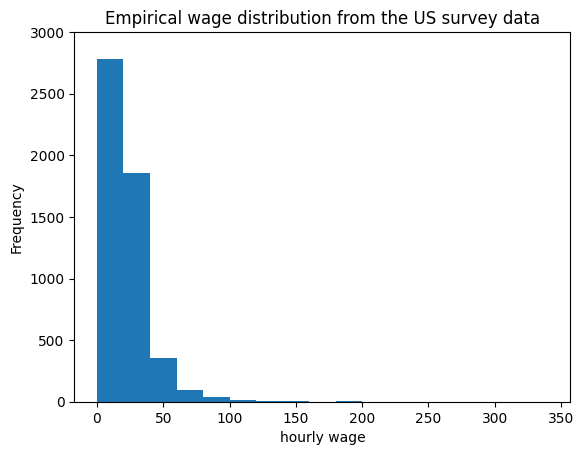

In [12]:
plt.hist(data.wage, bins=np.arange(0, 350, 20))
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical wage distribution from the US survey data')
plt.ylim((0, 3000))

(0.0, 3000.0)

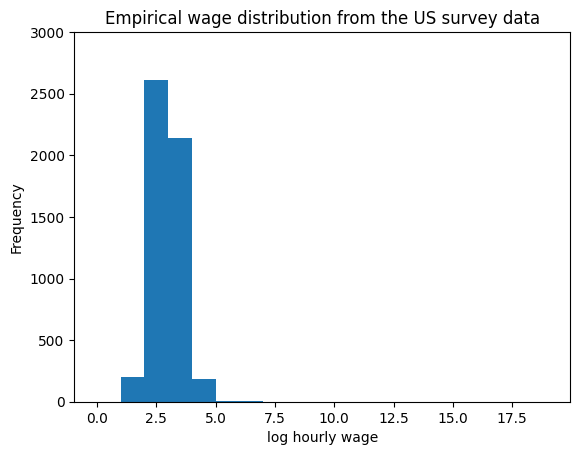

In [19]:
plt.hist(y, bins=np.arange(0, 20, 1))
plt.xlabel('log hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical wage distribution from the US survey data')
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$\log(\operatorname{wage}) = g(Z) + \epsilon.$$

In this notebook, we will evaluate *linear* prediction rules. In later notebooks, we will also utilize nonlinear prediction methods. In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$

Again, we generate $X$ in three ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., $\operatorname{exp}^2$ and $\operatorname{exp}^3$) and additional two-way interactions.

3. Extra Flexible Model: $X$ takes the flexible model and takes all pairwise interactions.

To evaluate the out-of-sample performance, we split the data first.

As known from our first lab, the basic model consists of $51$ regressors, and the flexible model has $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression and computing the $R^2$ on the test sample.

### Low dimensional specification (basic)

In [22]:
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

In [24]:
Z.shape

(5150, 18)

In [29]:
Zbase = patsy.dmatrix('0 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)',
                      Z, return_type='dataframe').values
print(Zbase) # Numpy 数组，连续变量保留原值，C() 分类变量生成哑变量， 0 表示不加截距项

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [31]:
Zbase.shape

(5150, 51)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(Zbase, y, test_size=0.25, random_state=123) #按照随机状态，把75%的数据作为训练集，20%用作测试集

In [36]:
X_train.shape

(3862, 51)

In [37]:
X_test.shape

(1288, 51)

In [40]:
y_train.shape

(3862,)

In [41]:
y_test.shape

(1288,)

In [42]:
lr_base = LinearRegression().fit(X_train, y_train)

Let's calculate R-squared on the test set

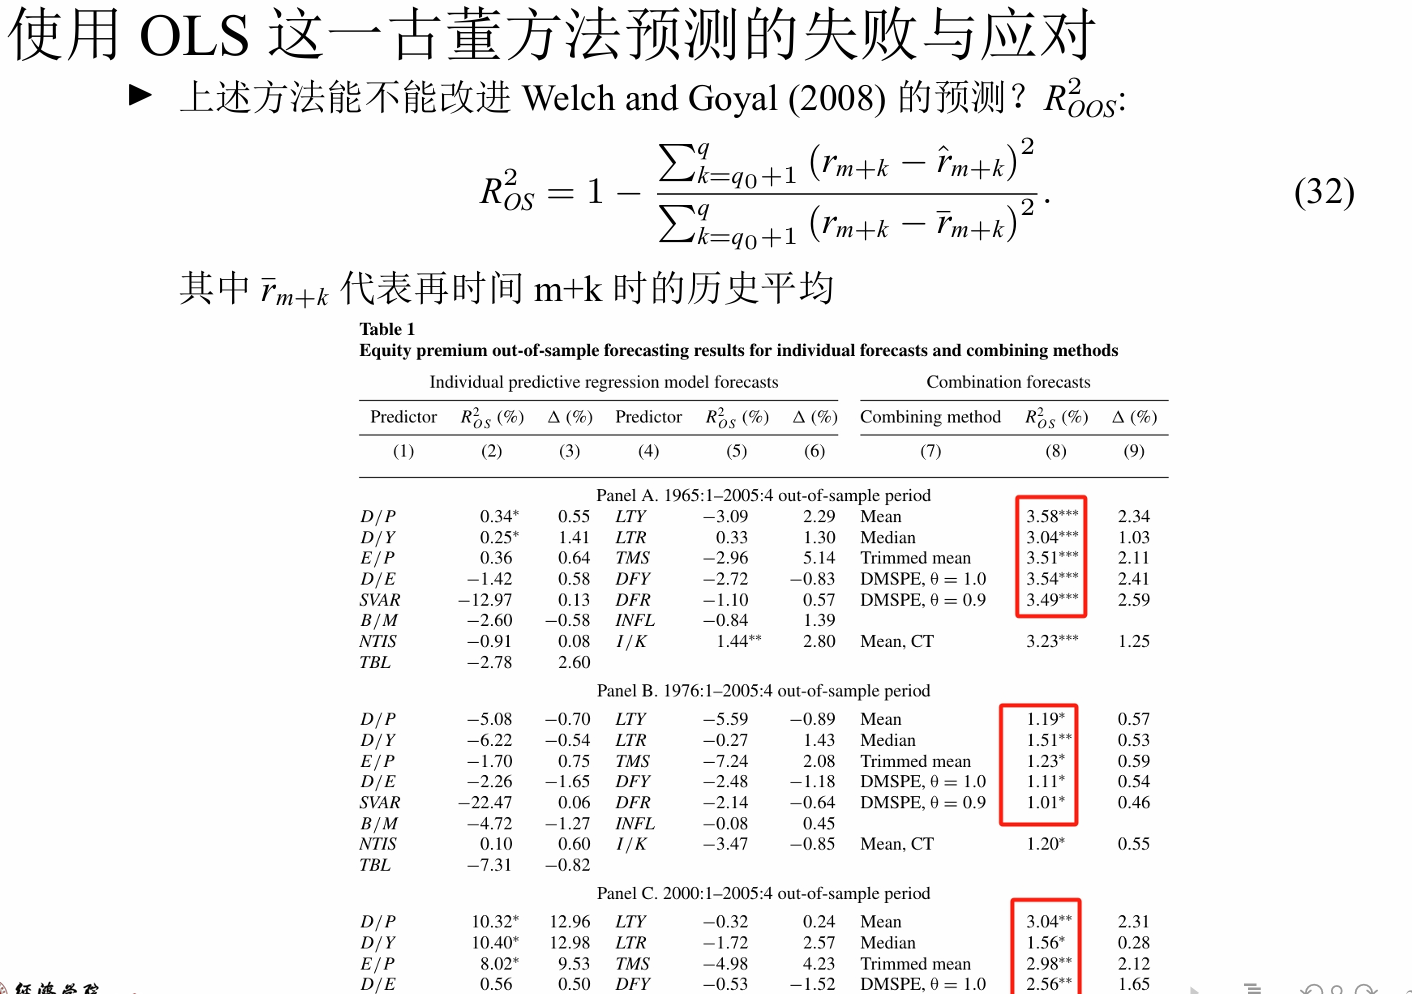

In [43]:
# 区别于OOS中的R2计算分母用的是 y_train
r2_base = 1 - np.mean((y_test - lr_base.predict(X_test))**2) / np.var(y_test)

print(f'{r2_base:.4f}')

0.2853


In fact `sklearn` provides an implementation

In [45]:
# sklearn 的 r2_score 计算：
r2_score(y_test, lr_base.predict(X_test))

0.285256437404931

Since out of sample performance can be vary for different train-test splits, it is more stable to look at average performance across multiple splits, using K-fold cross validation.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LinearRegression(), Zbase, y, scoring='r2', cv=cv)
print(f'{np.mean(rsquares):.4f}')

### High-dimensional specification (flexible)

We repeat the same procedure for the flexible model.

In [ ]:
Zflex = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)',
                      Z, return_type='dataframe').values

In [ ]:
Zflex.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Zflex, y, test_size=0.25, random_state=123)

In [ ]:
lr_flex = LinearRegression().fit(X_train, y_train)

In [ ]:
print(f'{r2_score(y_test, lr_flex.predict(X_test)):.4f}')

However, OLS can be quite unstable for such high-dimensional problems, and it really matters what solution is being returned among the multitude of solutions to the least squares objective -- the solution is non-unique in high-dimensional settings. For instance, we see that the `sklearn` implementation returns a numerically unstable solution whose error blows up in some cases.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LinearRegression(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

`sklearn`'s implementation uses the least squares solver from `scipy.linalg.lstsq`. If, for instance, we instead use a different pseudo-inverse based implementation, we get a different result

In [ ]:
class MyOLS(BaseEstimator):

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        CXX = (X.T @ X) / X.shape[0]
        CXy = (X.T @ y) / X.shape[0]
        self.coef_ = np.linalg.pinv(CXX) @ CXy
        return self

    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ self.coef_

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(MyOLS(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

This procedure also recovers the solution provided by `statsmodels.api.OLS`

In [ ]:
class StatsModelsOLS(BaseEstimator):

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.ols_ = sm.OLS(y, X).fit()
        return self

    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.ols_.predict(X)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(StatsModelsOLS(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

We can also choose different solvers by using `sklearn.linear_model.Ridge` which allows for no penalty and a multitude of solvers. We see that the `lsqr` solver is more stable than solvers based on singular value decompositions of the covariance matrix $E_n[X X']$.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(Ridge(alpha=0.0, solver='lsqr'), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(Ridge(alpha=0.0, solver='cholesky'), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(Ridge(alpha=0.0, solver='svd'), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

### Penalized regressions (flexible model)

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We proceed by running penalized regressions first for the flexible model, tuned via cross-validation.

First we try a pure `l1` penalty, tuned using cross-validation

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LassoCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Lasso): ', f'{np.mean(rsquares):.4f}')

Oops! For penalized regressions it is important that our features have the same standard deviation, so that we are symmetrically penalizing them

In [ ]:
from sklearn.preprocessing import StandardScaler
Zflex = StandardScaler().fit_transform(Zflex)

Let's try again!

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LassoCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Lasso): ', f'{np.mean(rsquares):.4f}')

Then we try a pure `l2` penalty, tuned using cross-validation

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(RidgeCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Ridge): ', f'{np.mean(rsquares):.4f}')

Finally, we try an equal combination of the two penalties, with the overall weight tuned using cross validation

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(ElasticNetCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Elastic Net): ', f'{np.mean(rsquares):.4f}')

We can also try a variant of the `l1` penalty, where the weight is chosen based on theoretical derivations. This is a based on a Python implementation that tries to replicate the main function of the hdm r-package. It was made by [Max Huppertz](https://maxhuppertz.github.io/code/). His library is this [repository](https://github.com/maxhuppertz/hdmpy). If not running on colab, download the repository and copy this folder to your site-packages folder. In my case, it is located here ***C:\Python\Python38\Lib\site-packages*** . It requires the multiprocess package ***pip install multiprocess***.

Specifically, we use "plug-in" tuning with a theoretically valid choice of penalty $\lambda = 2 \cdot c \hat{\sigma} \sqrt{n} \Phi^{-1}(1-\alpha/2p)$, where $c>1$ and $1-\alpha$ is a confidence level, $\Phi^{-1}$ denotes the quantile function, and $\hat{\sigma}$ is estimated in an iterative manner (see corresponding notes in book). Under homoskedasticity, this choice ensures that the Lasso predictor is well behaved, delivering good predictive performance under approximate sparsity. In practice, this formula will work well even in the absence of homoskedasticity, especially when the random variables $\epsilon$ and $X$ in the regression equation decay quickly at the tails.

In practice, many people choose to use cross-validation, which is perfectly fine for predictive tasks. However, when conducting inference, to make our analysis valid we will require cross-fitting in addition to cross-validation. As we have not yet discussed cross-fitting, we rely on this theoretically-driven penalty in order to allow for accurate inference in the upcoming notebooks.

In [ ]:
!git clone https://github.com/maxhuppertz/hdmpy.git
!pip install multiprocess

In [ ]:
# We wrap the package so that it has the familiar sklearn API
import hdmpy


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return X @ np.array(self.rlasso_.est['beta']).flatten() + self.rlasso_.est['intercept'].values

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(RLasso(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (RLasso): ', f'{np.mean(rsquares):.4f}')

Finally, we try the combination of a sparse and a dense coefficient using the LAVA method

In [ ]:
# We construct an sklearn API estimator that implements the LAVA method

class Lava(BaseEstimator):

    def __init__(self, *, alpha2=1, iterations=3):
        self.alpha2 = alpha2
        self.iterations = iterations

    def fit(self, X, y):
        lasso = RLasso(post=False).fit(X, y)
        ridge = Ridge(self.alpha2).fit(X, y - lasso.predict(X).flatten())

        for _ in range(self.iterations - 1):
            lasso = lasso.fit(X, y - ridge.predict(X))
            ridge = ridge.fit(X, y - lasso.predict(X).flatten())

        self.lasso_ = lasso
        self.ridge_ = ridge
        return self

    def predict(self, X):
        return self.lasso_.predict(X) + self.ridge_.predict(X)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(Lava(alpha2=20), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (LAVA): ', f'{np.mean(rsquares):.4f}')

<!-- We find that for this dataset the low dimensional OLS was the best among all specifications. The high-dimensional approaches did not manage to increase predictive power. -->
We find that for this dataset the low dimensional OLS is sufficient. The high-dimensional approaches did not manage to substantively increase predictive power.

### Extra high-dimensional specification (extra flexible)

We repeat the same procedure for the extra flexible model.

In [ ]:
Zextra = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)**2',
                       Z, return_type='dataframe').values
Zextra.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Zextra, y, test_size=0.25, random_state=123)
lr_extra = LinearRegression().fit(X_train, y_train)
print(f'{r2_score(y_test, lr_extra.predict(X_test)):.4f}')

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(StatsModelsOLS(), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'{np.mean(rsquares):.4f}')

#### Penalized regressions (extra flexible model)

Now let's repeat our penalized regression analysis for the extra flexible model. Note this block takes a while!

In [ ]:
Zextra = StandardScaler().fit_transform(Zextra)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LassoCV(cv=cv), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (Lasso): ', f'{np.mean(rsquares):.4f}')
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(RidgeCV(cv=cv), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (Ridge): ', f'{np.mean(rsquares):.4f}')
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(ElasticNetCV(cv=cv), Zextra, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (Elastic Net):', f'{np.mean(rsquares):.4f}')
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(RLasso(), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (RLasso):', f'{np.mean(rsquares):.4f}')
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(Lava(alpha2=20), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Extra flexible model R^2 (LAVA):', f'{np.mean(rsquares):.4f}')

As shown above, the overfitting effect is mitigated with the penalized regression model.